# Load all dependencies

In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters, Minimizer, fit_report

# Fit functions

In [2]:
def lorentz(x, x0, amplitude, gamma):
    ''' Lorentzian distribution to model the photon power spectrum.'''
    return amplitude / np.pi * 2*gamma / (4*(x - x0)**2 + gamma**2)


def lorentz_FPcavity(x, x0, gamma):
    ''' Lorentzian distribution to model the transmission of a Fabry-perot cavity'''
    return gamma**2 / (4*(x - x0)**2 + gamma**2)

def absorption(x, x0, OD, gamma):
    '''
    Optical absorption for an atomic cloud. 
    Modeled with the on-resonance OD and a frequency dependend lorentzian. 
    '''
    return np.exp(-OD * gamma**2 / (4*(x - x0)**2 + gamma**2))


def residuals(params, x_array, data=None, eps=None):
    ''' Define residual function for the fit optimizer. '''
    
    parvals = params.valuesdict()
    gamma_photon = parvals['gamma_photon']
    gamma_atom = parvals['gamma_atom']
    gamma_cavity = parvals['gamma_cavity']
    amplitude = parvals['amplitude']
    x0 = parvals['x0']
    OD = parvals['OD']
    
    to_omega = 1e6 * 2 * np.pi
    freq_array, dfreq = np.linspace(-80, 80, 1601, retstep=True)
    domega = dfreq * to_omega

    # create the spectral cavity lorentzian and convolve it with the absorption model
    lorentz_cavity = lorentz_FPcavity(freq_array*to_omega, x0, gamma_cavity)
    abs_model = lorentz(freq_array*to_omega, x0, amplitude, gamma_photon) * \
                        absorption(freq_array*to_omega, x0, OD, gamma_atom) * domega
    cavity_tx =  np.convolve(lorentz_cavity, abs_model, mode='same')

    model = [cavity_tx[freq_array==x_array[i]].item() for i in range(len(x_array))]

    if data is None:
        return model

    if eps is None:
        return model - data

    return (model - data) / eps

# Load the data for the spectra and define relevant bandwidths

In [3]:
freq, rate, rate_err = np.genfromtxt('./data_spectrum_initial_photon.csv').T[0:3]
freq_co, rate_co, rate_err_co = np.genfromtxt('./data_spectrum_compressed_photon.csv').T[0:3]


gamma_photon = 2 * np.pi * 20.623e6 # value from previouse fit to the exponential decay
gamma_cavity = 2 * np.pi *  2.6e6   # measured cavity bandwidth
gamma_disp_cavity = 2 * np.pi * 7.3e6 # measured dispersion cavity bandwidth
gamma_atom   = 2 * np.pi *  6.06e6  # atomic linewidth of the rb-87 D-lines

# Fit to initial photon spectrum

In [4]:
fit_params = Parameters()
fit_params.add('gamma_photon', value = gamma_photon, vary = False)
fit_params.add('gamma_atom', value=gamma_atom, vary = True)
fit_params.add('gamma_cavity', value=gamma_cavity, vary = False)
fit_params.add('x0', value=0, vary=False)
fit_params.add('amplitude', value=21)
fit_params.add('OD', value=1)

fit = Minimizer(residuals, fit_params, fcn_args=(freq, rate, rate_err))
result = fit.minimize()

print(fit_report(result))
print(np.array([8721561.13, 10603894.6])/(2*np.pi*1e6))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 46
    # variables        = 3
    chi-square         = 235.757331
    reduced chi-square = 5.48272863
    Akaike info crit   = 81.1714346
    Bayesian info crit = 86.6573588
[[Variables]]
    gamma_photon:  1.295781e+08 (fixed)
    gamma_atom:    9174643.59 +/- 10377491.9 (113.11%) (init = 3.80761e+07)
    gamma_cavity:  1.633628e+07 (fixed)
    x0:            0 (fixed)
    amplitude:     21.6595263 +/- 0.80429711 (3.71%) (init = 21)
    OD:            1.59372611 +/- 1.92531297 (120.81%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma_atom, OD)        = -0.974
    C(gamma_atom, amplitude) =  0.503
    C(amplitude, OD)         = -0.376
[1.38807957 1.68766224]


<IPython.core.display.Javascript object>


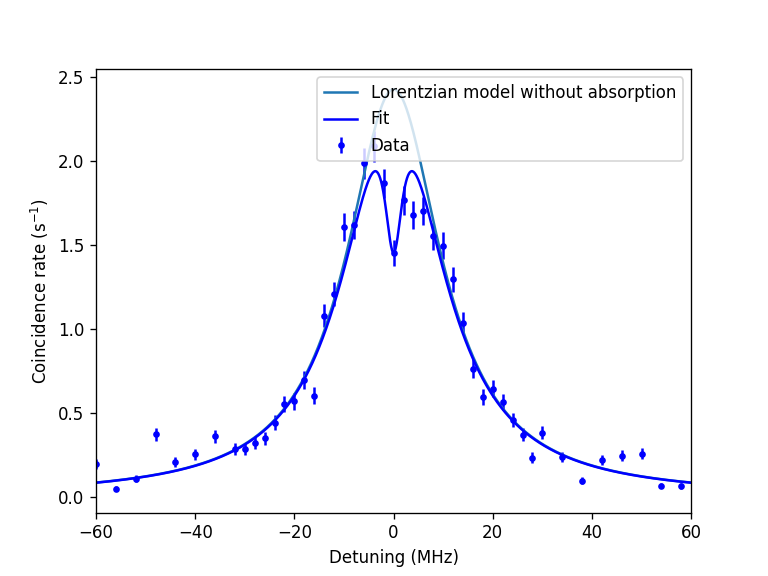

0.05937597507015672
1.0


In [5]:
result_vals = result.params.valuesdict()
amplitude = result_vals['amplitude']
x0 = result_vals['x0']
OD = result_vals['OD']


to_omega = 1e6 * 2 * np.pi
freq_array, dfreq = np.linspace(-80, 80, 1601, retstep=True)
domega = dfreq * to_omega

lorentz_cavity = lorentz_FPcavity(freq_array*to_omega, x0, gamma_cavity)
lorentz_photon = lorentz(freq_array*to_omega, x0, amplitude, gamma_photon) * domega
cavity_tx =  np.convolve(lorentz_cavity, lorentz_photon, mode='same')

plt.figure()
ax = plt.subplot(111) 

plt.plot(freq_array, 
         cavity_tx, 
         label='Lorentzian model without absorption') # lorentzians add

plt.plot(freq_array, residuals(result.params, x_array=freq_array), 'b', label='Fit')

plt.errorbar(freq, y=rate, yerr=rate_err,
             fmt='b.',
             alpha=1,
             label='Data')

ax.legend()
plt.xlabel('Detuning (MHz)')
plt.ylabel('Coincidence rate (s$^{-1}$)')
plt.xlim(-60, 60)
# plt.legend = True
print(np.max(lorentz(freq_array*to_omega, x0, amplitude, gamma_cavity + gamma_photon) * domega))
print(np.max(lorentz_cavity))

# plot compressed photon spectrum with cavity convolution

In [6]:
def dispersed_photon(t, gamma_cavity, gamma_photon, compressed=1):
    '''equation from paper'''
    # input params: g_c Gamma cavity, g_p Gamma photon
    phase = np.pi * ((t - 2 * np.log((gamma_cavity + gamma_photon) /
                                     (2 * gamma_cavity))/(gamma_photon - gamma_cavity)) > 0)
    phase_func = np.exp(-1j * phase * compressed)
    amplitude = np.sqrt(gamma_photon) * (2 * gamma_cavity * np.exp(-gamma_cavity*t/2) - (
        gamma_photon + gamma_cavity)*np.exp(-gamma_photon/2*t)) / (gamma_photon - gamma_cavity) * (t >= 0)
    return amplitude * phase_func


time_array, dt = np.linspace(0, 10000e-9, 200001, retstep=True)
not_compressed_spectrum = np.fft.fftshift(np.fft.fft(dispersed_photon(time_array, gamma_disp_cavity, gamma_photon, compressed=0), norm="ortho"))
disp_photon = dispersed_photon(time_array, gamma_disp_cavity, gamma_photon, compressed=1)
compressed_spectrum = np.fft.fftshift(np.fft.fft(disp_photon, norm="ortho"))

freq_fft_array = np.fft.fftshift(np.fft.fftfreq(time_array.size, dt))
df = 1 / (time_array.size * dt)

lorentz_spect_cavity = lorentz_FPcavity(freq_fft_array*2*np.pi, 0, gamma_cavity)
cavity_tx_cmprsd_photon =  np.convolve(lorentz_spect_cavity, amplitude * np.abs(compressed_spectrum)**2 * dt, mode='same')
cavity_tx_init_photon = np.convolve(lorentz_spect_cavity, amplitude * np.abs(not_compressed_spectrum)**2 * dt, mode='same')


# Sanity checks: Integral(|psi(t)|^2 * dt) = 1
print(np.sum(np.abs(compressed_spectrum)**2 * dt)) # "dt" is the correct scaling factor for the integral
print(np.sum(np.abs(not_compressed_spectrum)**2 * dt))
print(np.sum(np.abs(disp_photon)**2 * dt))
print(np.sum(lorentz(2 * np.pi * freq_fft_array, 0, 1, gamma_photon)*df*2*np.pi))
print("Frequency steps: ", df / 1e6, "MHz")

1.003245427690202
1.003245427690202
1.003245427690202
0.9993435497543898
Frequency steps:  0.09999950000249998 MHz


<IPython.core.display.Javascript object>


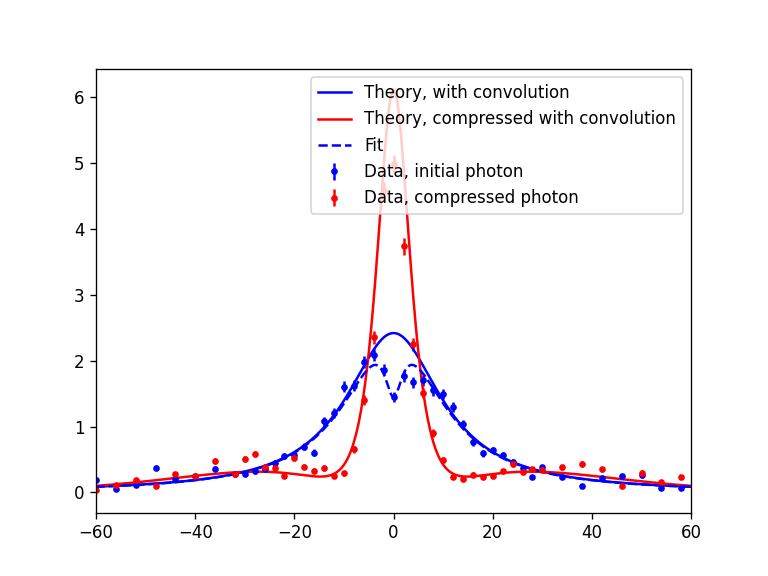

In [7]:
plt.figure()
ax = plt.subplot(111)

# plot data of initial photon and corresponing errors
plt.errorbar(freq, y=rate, yerr=rate_err,
             fmt='b.',
             alpha=1,
             label='Data, initial photon')

# plot initial photon power spectrum convolved with the spectral cavity transmission
plt.plot(freq_fft_array/1e6, cavity_tx_init_photon, 
         'b', label='Theory, with convolution')

# plot data of compressed photon and corresponding errors
plt.errorbar(freq_co, y=rate_co, yerr=rate_err_co,
             fmt='r.', alpha=1, label='Data, compressed photon')

# plot compressed photon power spectrum convolved with the spectral cavity transmission
plt.plot(freq_fft_array/1e6, cavity_tx_cmprsd_photon, 'r', label='Theory, compressed with convolution')

plt.plot(freq_array, residuals(result.params, x_array=freq_array), 'b--', label='Fit')

plt.xlim(-60, 60)
ax.legend()


np.savetxt('theory_initial_photon_power_spectrum_convolved_with_spec_cavity.csv',np.c_[freq_fft_array/1e6, cavity_tx_init_photon], header='frequency(MHz) coincidence_rate(per second)')
np.savetxt('theory_compressed_photon_power_spectrum_convolved_with_spec_cavity.csv',np.c_[freq_fft_array/1e6, cavity_tx_cmprsd_photon], header='frequency(MHz) coincidence_rate(per second)')
np.savetxt('fit_initial_photon_power_spectrum_with_OD_convolved_with_spec_cavity.csv',np.c_[freq_array, residuals(result.params, x_array=freq_array)], header='frequency(MHz) coincidence_rate(per second)')